In [1]:
import pandas as pd
import numpy as np
from minio import Minio
from io import BytesIO

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [2]:
client = Minio(
    "minio:9000",
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False,
)

BUCKET = "inmet-raw"
PREFIX = "wind/raw/"

objects = list(client.list_objects(BUCKET, prefix=PREFIX, recursive=True))
latest_obj = sorted(objects, key=lambda o:o.object_name)[-1]

response = client.get_object(BUCKET, latest_obj.object_name)
data = response.read()
response.close()
response.release_conn()

df = pd.read_parquet(BytesIO(data))
df.head()


,data,hora_utc,vento_direcao_(gr),vento_rajada_max_(m/s),vento_velocidade_(m/s)
0,2024/01/01,0000 UTC,41.0,"7,2","1,8"
1,2024/01/01,0100 UTC,44.0,"5,4","1,6"
2,2024/01/01,0200 UTC,15.0,"5,7","3,5"
3,2024/01/01,0300 UTC,9.0,"6,4",2
4,2024/01/01,0400 UTC,18.0,"3,5","1,6"


In [3]:
import numpy as np

# 1) Converter vírgula para ponto e tratar strings "None" / vazias
vel = (
    df["vento_velocidade_(m/s)"]
    .astype(str)
    .str.strip()
    .str.replace(",", ".", regex=False)
)

rajada = (
    df["vento_rajada_max_(m/s)"]
    .astype(str)
    .str.strip()
    .str.replace(",", ".", regex=False)
)

direcao = (
    df["vento_direcao_(gr)"]
    .astype(str)
    .str.strip()
    .str.replace(",", ".", regex=False)
)

# 2) Converter para float, forçando valores inválidos para NaN
df["vento_velocidade_(m/s)"] = pd.to_numeric(vel, errors="coerce")
df["vento_rajada_max_(m/s)"] = pd.to_numeric(rajada, errors="coerce")
df["vento_direcao_(gr)"] = pd.to_numeric(direcao, errors="coerce")

# 3) Remover linhas em que direção ou velocidade não fazem sentido (NaN)
df = df.dropna(subset=["vento_velocidade_(m/s)", "vento_direcao_(gr)"]).reset_index(drop=True)

df[["vento_direcao_(gr)", "vento_rajada_max_(m/s)", "vento_velocidade_(m/s)"]].head()


,vento_direcao_(gr),vento_rajada_max_(m/s),vento_velocidade_(m/s)
0,41.0,7.2,1.8
1,44.0,5.4,1.6
2,15.0,5.7,3.5
3,9.0,6.4,2.0
4,18.0,3.5,1.6


In [4]:
# converter graus → radianos
df["theta_rad"] = np.deg2rad(df["vento_direcao_(gr)"])

# componentes vetoriais (resumo físico do vento)
df["u"] = df["vento_velocidade_(m/s)"] * np.sin(df["theta_rad"])
df["v"] = df["vento_velocidade_(m/s)"] * np.cos(df["theta_rad"])

df[["vento_velocidade_(m/s)", "vento_direcao_(gr)", "u", "v"]].head()


,vento_velocidade_(m/s),vento_direcao_(gr),u,v
0,1.8,41.0,1.180906,1.358477
1,1.6,44.0,1.111453,1.150944
2,3.5,15.0,0.905867,3.380740
3,2.0,9.0,0.312869,1.975377
4,1.6,18.0,0.494427,1.521690


In [5]:
df["theta_rad"] = np.deg2rad(df["vento_direcao_(gr)"])

df["u"] = df["vento_velocidade_(m/s)"] * np.sin(df["theta_rad"])
df["v"] = df["vento_velocidade_(m/s)"] * np.cos(df["theta_rad"])

df[["data", "hora_utc", "u", "v"]].head()


,data,hora_utc,u,v
0,2024/01/01,0000 UTC,1.180906,1.358477
1,2024/01/01,0100 UTC,1.111453,1.150944
2,2024/01/01,0200 UTC,0.905867,3.380740
3,2024/01/01,0300 UTC,0.312869,1.975377
4,2024/01/01,0400 UTC,0.494427,1.521690


In [6]:
df_day = df.groupby("data", as_index=False).agg(
    u=("u", "mean"),
    v=("v", "mean"),
    vento_velocidade=("vento_velocidade_(m/s)", "mean"),
    vento_rajada=("vento_rajada_max_(m/s)", "mean"),
    vento_direcao=("vento_direcao_(gr)", "mean"),
)

df_day["data"] = pd.to_datetime(df_day["data"], format="%Y/%m/%d")
df_day = df_day.sort_values("data").reset_index(drop=True)

df_day.head()


,data,u,v,vento_velocidade,vento_rajada,vento_direcao
0,2024-01-01,0.435891,0.863808,1.475000,4.425000,98.375000
1,2024-01-02,0.335957,1.786309,2.087500,5.308333,196.875000
2,2024-01-03,1.127706,2.600232,2.912500,6.970833,39.708333
3,2024-01-04,1.290745,1.912114,2.345833,6.325000,35.541667
4,2024-01-05,1.252321,1.390540,2.000000,5.879167,46.333333


In [7]:
features = ["u", "v", "vento_velocidade", "vento_rajada"]

X_day = df_day[features].copy()

mask = X_day.notna().all(axis=1)
df_day_clean = df_day[mask].reset_index(drop=True)
X_day = df_day_clean[features].copy()

scaler = StandardScaler()
Xd = scaler.fit_transform(X_day)

Xd[:5]


array([[-3.03647964,  0.84499334, -1.59514078, -2.20312802],
       [-3.2772296 ,  1.57736979, -0.38253349, -1.4623158 ],
       [-1.36982809,  2.22354587,  1.25077429, -0.06805129],
       [-0.97705042,  1.67724697,  0.12890632, -0.60968287],
       [-1.06961825,  1.26316792, -0.5557631 , -0.98358338]])

In [8]:
scores_day = {}

for k in range(2, 10):
    kmd = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(Xd)
    score = silhouette_score(Xd, kmd.labels_)
    scores_day[k] = score
    print(f"K={k}: silhouette={score:.4f}")


K=2: silhouette=0.3220
K=3: silhouette=0.3382
K=4: silhouette=0.3547
K=5: silhouette=0.2974
K=6: silhouette=0.3282
K=7: silhouette=0.2823
K=8: silhouette=0.3041
K=9: silhouette=0.2921


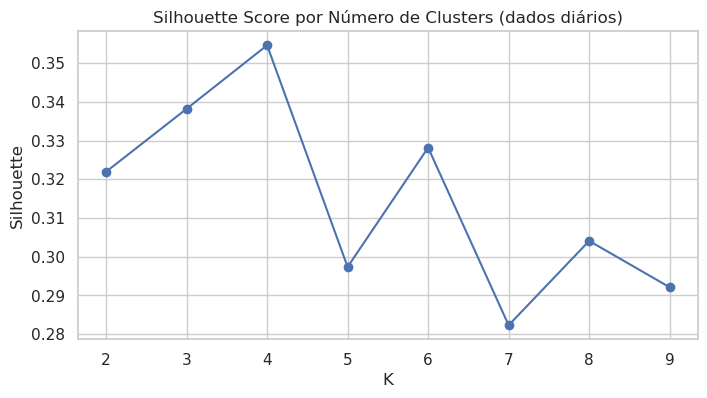

In [9]:
plt.figure(figsize=(8,4))
plt.plot(list(scores_day.keys()), list(scores_day.values()), marker="o")
plt.title("Silhouette Score por Número de Clusters (dados diários)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()


In [10]:
K = 4  # <<< AJUSTE AQUI

model_day = KMeans(n_clusters=K, random_state=42, n_init="auto").fit(Xd)
df_day_clean["cluster"] = model_day.labels_

df_day_clean.head()


,data,u,v,vento_velocidade,vento_rajada,vento_direcao,cluster
0,2024-01-01,0.435891,0.863808,1.475000,4.425000,98.375000,3
1,2024-01-02,0.335957,1.786309,2.087500,5.308333,196.875000,3
2,2024-01-03,1.127706,2.600232,2.912500,6.970833,39.708333,2
3,2024-01-04,1.290745,1.912114,2.345833,6.325000,35.541667,3
4,2024-01-05,1.252321,1.390540,2.000000,5.879167,46.333333,3


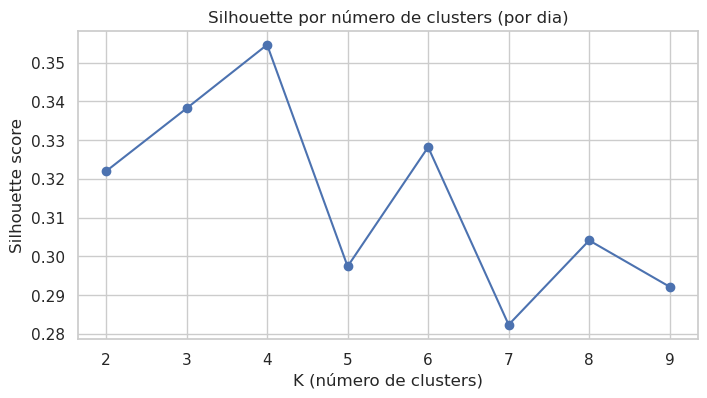

In [11]:
plt.figure(figsize=(8,4))
plt.plot(list(scores_day.keys()), list(scores_day.values()), marker="o")
plt.title("Silhouette por número de clusters (por dia)")
plt.xlabel("K (número de clusters)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()


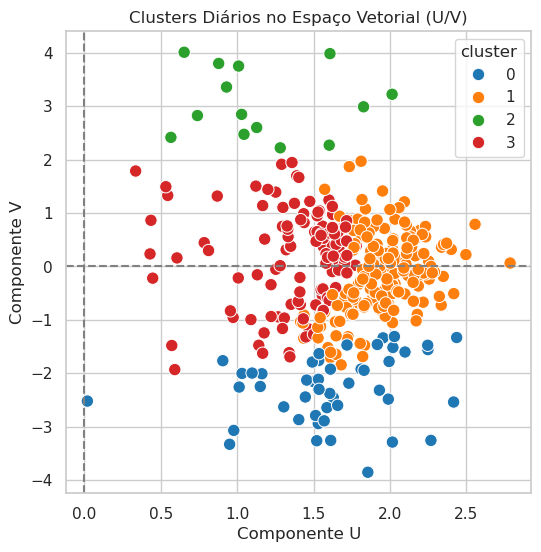

In [12]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df_day_clean,
    x="u",
    y="v",
    hue="cluster",
    palette="tab10",
    s=80
)
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.title("Clusters Diários no Espaço Vetorial (U/V)")
plt.xlabel("Componente U")
plt.ylabel("Componente V")
plt.show()


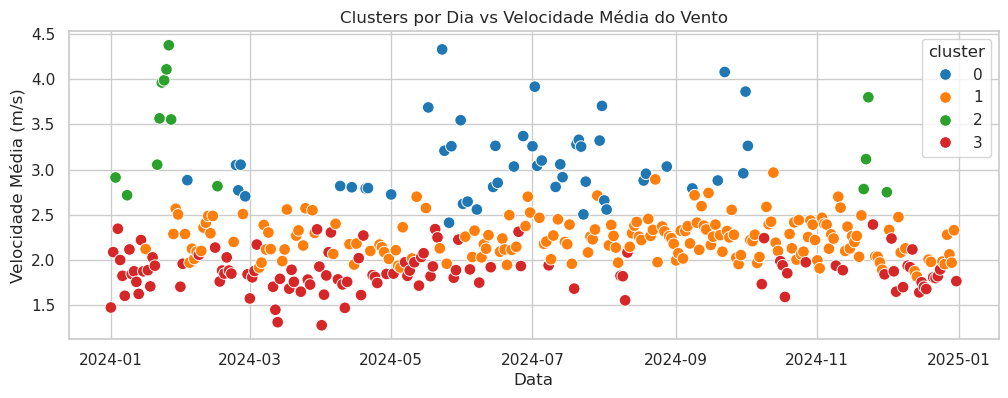

In [13]:
plt.figure(figsize=(12,4))
sns.scatterplot(
    data=df_day_clean,
    x="data",
    y="vento_velocidade",
    hue="cluster",
    palette="tab10",
    s=70
)
plt.title("Clusters por Dia vs Velocidade Média do Vento")
plt.xlabel("Data")
plt.ylabel("Velocidade Média (m/s)")
plt.show()


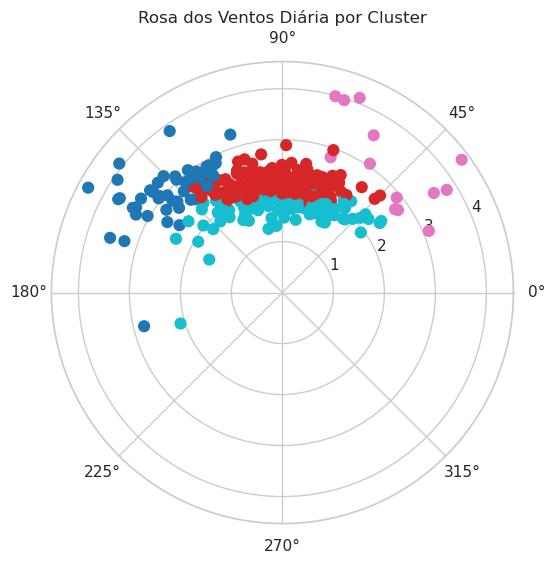

In [14]:
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

angles = np.deg2rad(df_day_clean["vento_direcao"])
speeds = df_day_clean["vento_velocidade"]
clusters = df_day_clean["cluster"]

scatter = ax.scatter(angles, speeds, c=clusters, cmap="tab10", s=60)

plt.title("Rosa dos Ventos Diária por Cluster")
plt.show()


In [15]:
cluster_summary = df_day_clean.groupby("cluster").agg({
    "vento_velocidade": ["mean", "std"],
    "vento_rajada": ["mean", "std"],
    "vento_direcao": ["mean", "std"],
    "u": "mean",
    "v": "mean",
    "data": "count"
}).rename(columns={"data": "num_dias"})

cluster_summary


vento_velocidade           vento_rajada           vento_direcao  \
                    mean       std         mean       std          mean   
cluster                                                                   
0               3.066710  0.416863     8.799886  0.962852    137.557337   
1               2.238164  0.209898     7.268847  0.630018     92.575175   
2               3.393155  0.579887     7.945856  0.847929     54.828068   
3               1.872874  0.215163     5.822476  0.660802     87.891554   

                           u         v num_dias  
               std      mean      mean    count  
cluster                                          
0        14.823855  1.625210 -2.251759       49  
1        17.861966  1.949104 -0.141805      188  
2        27.757811  1.165103  3.054503       14  
3        29.880817  1.372381  0.187911      113

In [16]:
df_day_clean.to_csv("vento_clusters_diarios.csv", index=False)
df_day_clean.head()


,data,u,v,vento_velocidade,vento_rajada,vento_direcao,cluster
0,2024-01-01,0.435891,0.863808,1.475000,4.425000,98.375000,3
1,2024-01-02,0.335957,1.786309,2.087500,5.308333,196.875000,3
2,2024-01-03,1.127706,2.600232,2.912500,6.970833,39.708333,2
3,2024-01-04,1.290745,1.912114,2.345833,6.325000,35.541667,3
4,2024-01-05,1.252321,1.390540,2.000000,5.879167,46.333333,3
